In [12]:
# run sanitaion_and_fiedler_value.ipynb before running this
import pickle
import numpy as np
from scipy.linalg import eigh

In [ ]:
def compute_conductance(A_sub, mask1, mask2):
    """
    Compute conductance of a cut defined by mask1 and mask2.
    
    Conductance = cut(S, S') / min(vol(S), vol(S'))
    """
    cut_weight = np.sum(A_sub[np.ix_(mask1, mask2)])
    vol1 = np.sum(A_sub[mask1, :])
    vol2 = np.sum(A_sub[mask2, :])
    min_vol = min(vol1, vol2)
    if min_vol == 0:
        return float('inf')
    return cut_weight / min_vol

# ======================================================
# Recursive Fiedler Segmentation
# ======================================================

def recursive_fiedler(A, nodes=None, normalized=False, lambda2_thresh=None, conductance_thresh=None, verbose=False):
    """
    Minimal recursive Fiedler bisection.
    Stopping rule: λ2 > lambda2_thresh or conductance > conductance_thresh
    """
    if nodes is None:
        nodes = np.arange(A.shape[0])
    nodes = np.asarray(nodes)
    n_nodes = len(nodes)
    
    # Stop trivially small clusters
    if n_nodes <= 2:
        return [nodes]
    
    # Subgraph
    A_sub = A[np.ix_(nodes, nodes)]
    degs = A_sub.sum(axis=1)
    
    # Laplacian
    if not normalized:
        L = np.diag(degs) - A_sub
    else:
        with np.errstate(divide='ignore'):
            inv_sqrt = 1.0 / np.sqrt(degs + 1e-12)
        inv_sqrt[~np.isfinite(inv_sqrt)] = 0.0
        D_inv_sqrt = np.diag(inv_sqrt)
        L = np.eye(n_nodes) - D_inv_sqrt @ A_sub @ D_inv_sqrt
    
    # Eigen decomposition
    vals, vecs = eigh(L)
    lambda2 = vals[1]
    
    if verbose:
        print(f"n={n_nodes} λ2={lambda2:.4f}")
    
    # Stop if λ2 is too large (cluster is tight)
    if lambda2_thresh:
        if lambda2 > lambda2_thresh:
            return [nodes]
    
    # Split by Fiedler sign
    fiedler = vecs[:, 1]
    mask1 = fiedler > 0
    mask2 = fiedler <= 0
    cluster1 = nodes[mask1]
    cluster2 = nodes[mask2]
    
    # Stop if split is trivial
    if len(cluster1) == 0 or len(cluster2) == 0:
        return [nodes]
    
    # Check conductance if threshold provided
    if conductance_thresh:
        conductance = compute_conductance(A_sub, mask1, mask2)
        if verbose:
            print(f"  conductance={conductance:.4f}")
        if conductance > conductance_thresh:
            return [nodes]
    
    # Recurse
    return recursive_fiedler(A, cluster1, normalized, lambda2_thresh, conductance_thresh, verbose) + \
           recursive_fiedler(A, cluster2, normalized, lambda2_thresh, conductance_thresh, verbose)


In [48]:
with open("samples_by_period.pkl", "rb") as f:
    samples_by_period = pickle.load(f)
with open("corr_by_period.pkl", "rb") as f:
    corr_by_period = pickle.load(f)

clusterings_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    samples = samples_by_period[period]
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    # threshold 1 is chosen as it is the highest lambda2 observed across periods and is also at a time where market is relatively stable and homogeneous
    # conductance_thresh is set to None to disable conductance based stopping criteria, since it was observed to be too restrictive due to the fact that correlation matrices are dense
    # base conductance is observed to be quite high (>0.5) even for intuitive splits
    clusters = recursive_fiedler(A, normalized=True, lambda2_thresh=0.95, conductance_thresh=None, verbose=False)
    clusterings_by_period[period] = {
        'samples': samples,
        'clusters': clusters
    }

fiedler_value_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    from scipy.sparse import csgraph
    L_norm = csgraph.laplacian(A, normed=True)
    
    # eigenvalues
    eigvals = np.linalg.eigvalsh(L_norm)
    
    # Fiedler value (second-smallest)
    fiedler_value_by_period[period] = eigvals[1]

# # Cluster information
# for period, data in clusterings_by_period.items():
#     samples = data['samples']
#     clusters = data['clusters']
#     print(f"Period: {period}, Number of clusters: {len(clusters)}")
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i+1}: Size {len(cluster)}")

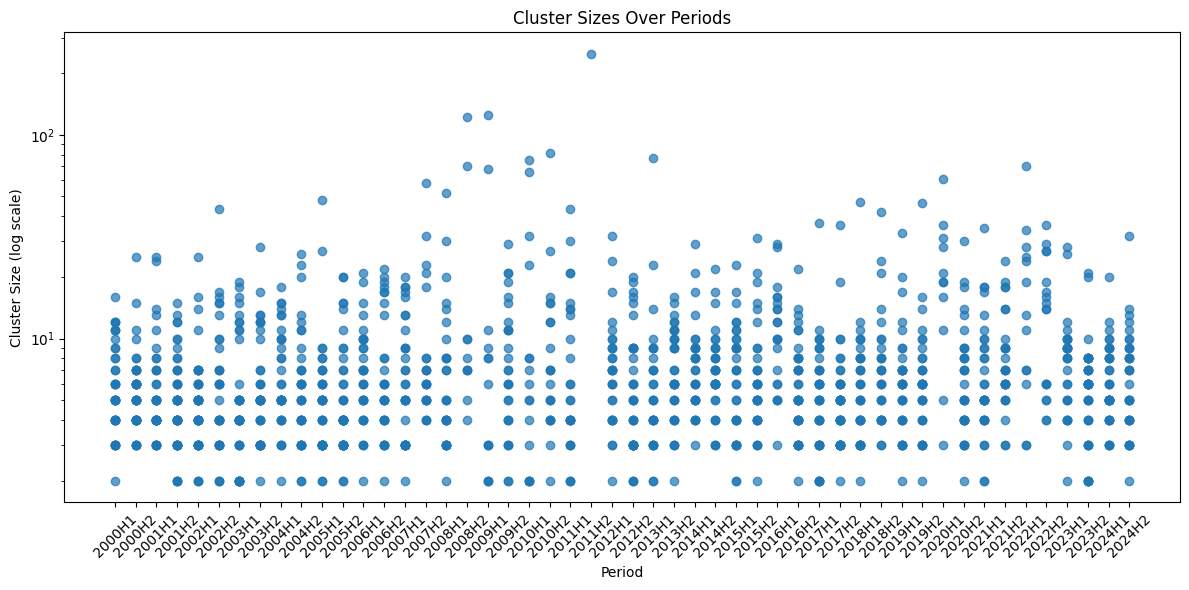

In [49]:
import matplotlib.pyplot as plt

periods = list(clusterings_by_period.keys())

plt.figure(figsize=(12, 6))

for i, period in enumerate(periods):
    sizes = [len(cluster) for cluster in clusterings_by_period[period]['clusters']]
    plt.scatter([i]*len(sizes), sizes, color='C0', alpha=0.7)

plt.yscale('log')  # if cluster sizes vary a lot
plt.xticks(ticks=range(len(periods)), labels=periods, rotation=45)
plt.xlabel('Period')
plt.ylabel('Cluster Size (log scale)')
plt.title('Cluster Sizes Over Periods')
plt.tight_layout()
plt.show()

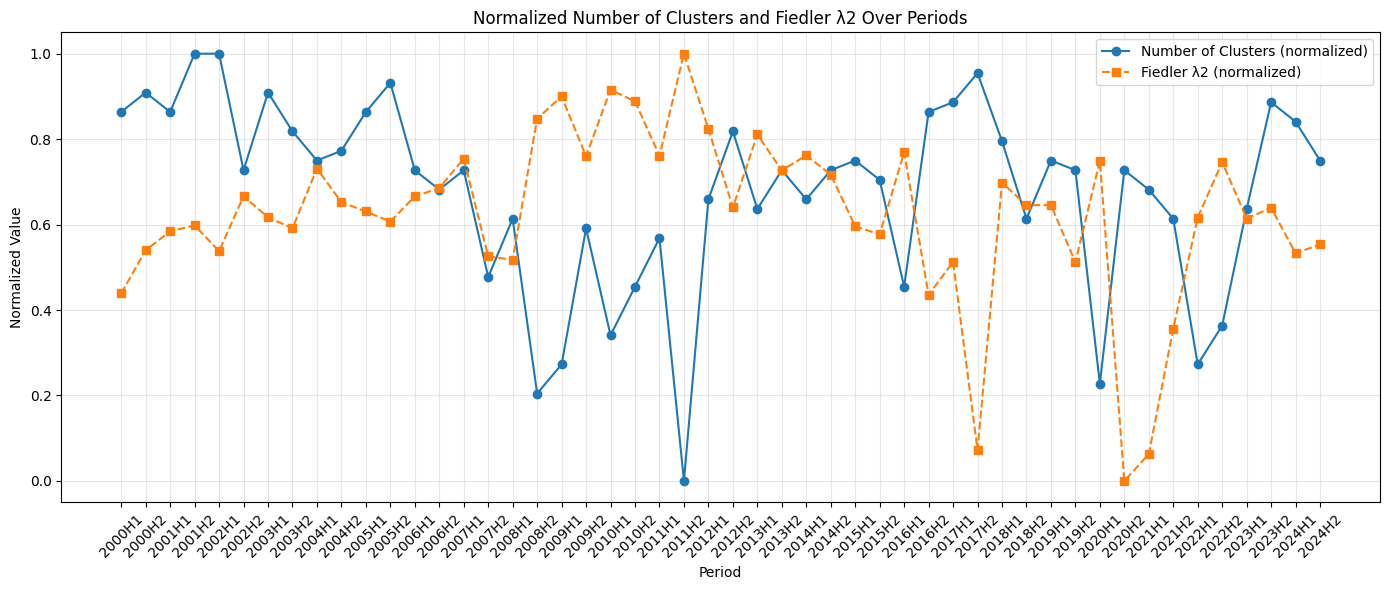

In [50]:

periods = list(clusterings_by_period.keys())
num_clusters = np.array([len(clusterings_by_period[period]['clusters']) for period in periods])
fiedler_values = np.array([fiedler_value_by_period[period] for period in periods])

# Normalize both series to 0-1
num_clusters_norm = (num_clusters - num_clusters.min()) / (num_clusters.max() - num_clusters.min())
fiedler_values_norm = (fiedler_values - fiedler_values.min()) / (fiedler_values.max() - fiedler_values.min())

plt.figure(figsize=(14, 6))
plt.plot(periods, num_clusters_norm, marker='o', linestyle='-', label='Number of Clusters (normalized)')
plt.plot(periods, fiedler_values_norm, marker='s', linestyle='--', label='Fiedler λ2 (normalized)')

plt.xticks(rotation=45)
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.title('Normalized Number of Clusters and Fiedler λ2 Over Periods')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()